In [1]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
!pip install scikit-learn==1.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [3]:
import sklearn 
print(sklearn.__version__)

1.6.1


In [4]:
!pip install wfdb --quiet
#!pip install keras-tuner --quiet
#!pip install resnet1d
!pip install tqdm --quiet

In [5]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
import os
from tqdm import tqdm


# Predection

## preprocess Functions


In [6]:
def bandpass_filter(signal, fs=250, lowcut=0.5,  highcut=15.0,  order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
def smooth_signal(data, window_size=5):
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)

## Prediction Functions

In [7]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, signal_name, model_name, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # Convert indices to time (seconds)

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}
    added_labels = set()

    # Convert zoom limits to sample indices
    zoom_start_idx = int(zoom[0] * fs)
    zoom_end_idx = int(zoom[1] * fs) if zoom[1] is not None else len(signal)

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            # Only plot if within zoom range
            if start >= zoom_start_idx and end <= zoom_end_idx:
                label = f'Predicted {wave_type}' if wave_type not in added_labels else None
                plt.fill_between(
                    time[start:end],
                    -1, 1,
                    color=wave_colors.get(wave_type, 'gray'),
                    alpha=0.3,
                    label=label
                )
                added_labels.add(wave_type)

    plt.legend(loc='upper right')
    plt.title(f"signal: {signal_name}, model: {model_name}", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Apply zoom
    plt.xlim(zoom[0], zoom[1] if zoom[1] is not None else time[-1])

    plt.show()


# Features extraction

## extract features functions

In [9]:
import numpy as np
from scipy.stats import skew, kurtosis, entropy
import tensorflow as tf

R_model = tf.keras.models.load_model("/kaggle/input/r-detection/tensorflow2/default/2/R_detection.h5")

# Preprocess qrs_wave the same way as during training
def preprocess_qrs_wave(wave, target_length=250):
    wave = wave.astype(np.float32)
    # Normalize
    wave = (wave - np.mean(wave)) / (np.std(wave) + 1e-8)
    # Pad or truncate to target length
    if len(wave) < target_length:
        wave = np.pad(wave, (0, target_length - len(wave)), mode='constant')
    else:
        wave = wave[:target_length]
    return wave.reshape(1, -1, 1)

def extract_features_per_qrs(signal ,mask, fs=250):
    features_list = []
    #time = np.arange(len(signal)) / fs
    n = len(signal)

    # Find all QRS starts
    
    qrs_mask = (mask == 2).astype(np.int8)
    transitions = np.diff(qrs_mask, prepend=0)
    qrs_starts = np.flatnonzero(transitions == 1)
    qrs_ends = np.flatnonzero(transitions == -1) - 1

    if len(qrs_ends) < len(qrs_starts):
        qrs_ends = np.append(qrs_ends, n - 1)
    
    previous_r_index = None  # To calculate RR interval

    for i in tqdm(range(len(qrs_starts)), desc="extract features"):
        
        

        p_wave = np.array([])
        qrs_wave = np.array([])
        t_wave = np.array([])
        p_indices = np.array([])
        t_indices = np.array([])


        qrs_start = qrs_starts[i]
        # Find QRS end within the current segment
        qrs_end = qrs_ends[i]
        next_qrs_start = qrs_starts[i+1] if i < len(qrs_starts) - 1 else len(mask)

        
        qrs_indices = np.arange(qrs_start, qrs_end + 1)[mask[qrs_start:qrs_end+1] == 2]
        
        if len(qrs_indices) <= 1:
            continue
        
        # Search for the P wave just before this QRS (no QRS or T in between)
        start_idx = qrs_ends[i-1]-1 if i > 0 else 0
        p_indices = np.where(mask[start_idx:qrs_start] == 1)[0]+start_idx
        valid_p = []
        for p_end in reversed(p_indices):
                if np.all(mask[p_end:qrs_start] != 2) and np.all(mask[p_end:qrs_start] != 3):
                    p_start = p_end
                    while p_start > 0 and mask[p_start - 1] == 1:
                        p_start -= 1
                    valid_p = list(range(p_start, p_end + 1))
                    break

        # Search for the T wave just after this QRS (no QRS or P in between)

        t_indices = np.where(mask[qrs_end:next_qrs_start] == 3)[0]
        t_indices = t_indices + (qrs_end )
        
        valid_t = []
        for t_start_offset in t_indices:
            t_start = t_start_offset
            if np.all(mask[qrs_end+1:t_start] != 2) and np.all(mask[qrs_end+1:t_start] != 1):
                #print("got t")
                t_end = t_start
                while t_end < len(mask) - 1 and mask[t_end + 1] == 3:
                    t_end += 1
                valid_t = list(range(t_start, t_end + 1))
                break
        # Extract samples
        valid_p = [i for i in valid_p if i < len(signal)]
        p_wave = signal[valid_p] if valid_p else np.array([])
        
        qrs_indices = [i for i in qrs_indices if i < len(signal)]
        if len(qrs_indices) <= 1:
            continue
        
        qrs_indices = np.array(qrs_indices)
        
        qrs_wave = signal[qrs_indices]
        valid_t = [i for i in valid_t if i < len(signal)]
        t_wave = signal[valid_t] if valid_t else np.array([])
        p_indices = valid_p if valid_p else np.array([])
        t_indices = valid_t if valid_t else np.array([])
        
        f = {}
        padding = 0
        
        if len(p_wave)>0:
          f['start'] = p_indices[0]-padding if p_indices[0] > padding else 0
          
        else :
          f['start'] = qrs_indices[0]-padding if qrs_indices[0] > padding else 0

        if len(t_wave)>0:
          f['end'] = t_indices[-1]+padding if t_indices[-1] < len(signal)-padding else len(signal)
          
        else :
          f['end'] = qrs_indices[-1]+padding if qrs_indices[-1] < len(signal)-padding else len(signal)


        p_start,p_end,t_start,t_end = None,None,None,None
        if len(p_wave)>0:
            p_start = p_indices[0]
            p_end = p_indices[-1]
        if len(t_wave)>0:
            t_start = t_indices[0]
            t_end = t_indices[-1]
        f['qrs_start'] = qrs_indices[0]
        f['qrs_end'] =  qrs_indices[-1]
        f['p_start'] = p_start
        f['p_end'] =  p_end
        f['t_start'] = t_start
        f['t_end'] =  t_end
        


        f['Duree_P_ms'] = len(p_wave) / fs * 1000 if len(p_wave) > 0 else 0
        f['Duree_QRS_ms'] = len(qrs_wave) / fs * 1000 if len(qrs_wave) > 0 else 0
        f['Duree_T_ms'] = len(t_wave) / fs * 1000 if len(t_wave) > 0 else 0

        f['Intervalle_PR_ms'] = ((qrs_start - valid_p[0]) / fs * 1000) if valid_p else 0
        f['Intervalle_QT_ms'] = ((valid_t[-1] - qrs_start) / fs * 1000) if valid_t else 0
        f['Intervalle_ST_ms'] = ((valid_t[0] - qrs_end) / fs * 1000) if valid_t else 0


        # Amplitude_P
        if len(p_wave) > 0:
          default_start = (p_wave[0]+p_wave[-1])/2 if len(p_wave) > 0 else 0
          p_index = p_indices[np.argmax(np.abs(signal[p_indices]-default_start))]
          p_amplitude = signal[p_index]
          f['P_index']= p_index
          f['Amplitude_P'] = p_amplitude
        else:
          f['P_index']= 0
          f['Amplitude_P'] = 0

        # Amplitude_R
        all_wave = signal[int(f['start']):int(f['end'])]
        all_indices = range(int(f['start']),int(f['end']))
        R_window_input = preprocess_qrs_wave(all_wave)
        prediction = R_model.predict(R_window_input,verbose=0)[0]  
        # Find predicted R-peak
        predicted_r_relative = np.argmax(prediction)
       
        if (predicted_r_relative>len(range(all_indices[0],qrs_indices[-1]))):
            r_index = qrs_indices[-1]
        else:
            predicted_r_relative = min(predicted_r_relative,len(all_indices)-1)
            r_index = all_indices[predicted_r_relative]
        
        r_amplitude = signal[r_index]

        f['R_index']= r_index# Preprocess qrs_wave the same way as during training


        f['Amplitude_R'] = r_amplitude
        # RR interval
        if previous_r_index is not None:
            f['Intervalle_RR_ms'] = (r_index - previous_r_index) / fs * 1000
        else:
            f['Intervalle_RR_ms'] = np.nan   # Or np.nan if you prefer

        # Update previous_r_index for next beat
        previous_r_index = r_index

        # --- Detect Q and S waves relative to R ---
        q_index, s_index = None, None
        q_amplitude, s_amplitude = None, None

        if r_amplitude > np.median(signal[qrs_indices]):  # R is a max peak
            q_candidates = qrs_indices[qrs_indices < r_index]
            s_candidates = qrs_indices[qrs_indices > r_index]
            if len(q_candidates) > 0:
                q_index = q_candidates[np.argmin(signal[q_candidates])]
                q_amplitude = signal[q_index]
            if len(s_candidates) > 0:
                s_index = s_candidates[np.argmin(signal[s_candidates])]
                s_amplitude = signal[s_index]
        else:  # R is a min peak
            q_candidates = qrs_indices[qrs_indices < r_index]
            s_candidates = qrs_indices[qrs_indices > r_index]
            if len(q_candidates) > 0:
                q_index = q_candidates[np.argmax(signal[q_candidates])]
                q_amplitude = signal[q_index]
            if len(s_candidates) > 0:
                s_index = s_candidates[np.argmax(signal[s_candidates])]
                s_amplitude = signal[s_index]

        # Add Q and S info
        f['Q_index'] = q_index if q_index is not None else 0
        f['Amplitude_Q'] = q_amplitude if q_amplitude is not None else 0
        f['S_index'] = s_index if s_index is not None else 0
        f['Amplitude_S'] = s_amplitude if s_amplitude is not None else 0


        # Amplitude_T
        if len(t_wave) > 0:
          default_start = (t_wave[0]+t_wave[-1])/2 if len(t_wave) > 0 else 0
          # print(default_start)
          t_index = t_indices[np.argmax(np.abs(signal[t_indices]-default_start))]
          t_amplitude = signal[t_index]
          f['T_index']= t_index
          f['Amplitude_T'] = t_amplitude
        else:
          f['T_index']= 0
          f['Amplitude_T'] = 0

        # Amplitude Ratio
        f['T/R_ratio'] = np.max(np.abs(t_wave)) / np.max(np.abs(qrs_wave)) if len(t_wave) > 0 and len(qrs_wave) > 0 else 0
        f['P/R_ratio'] = np.max(np.abs(p_wave)) / np.max(np.abs(qrs_wave)) if len(p_wave) > 0 and len(qrs_wave) > 0 else 0


        # Pente (slopes)
        f['QRS_area'] = np.trapz(np.abs(qrs_wave), dx=1/fs)

        # QR Slope
        if q_index is not None and q_index < r_index:
            delta_qr = (r_amplitude - q_amplitude)
            time_qr = (r_index - q_index) / fs
            f['Slope_QR'] = delta_qr / time_qr if time_qr != 0 else 0
        else:
            f['Slope_QR'] = 0

        # RS Slope
        if s_index is not None and r_index < s_index:
            delta_rs = (s_amplitude - r_amplitude)
            time_rs = (s_index - r_index) / fs
            f['Slope_RS'] = delta_rs / time_rs if time_rs != 0 else 0
        else:
            f['Slope_RS'] = 0

        # --- P wave symmetry ---
        if len(p_wave) > 2:
            mid = len(p_wave) // 2
            left = p_wave[:mid]
            right = p_wave[mid:]
            f['P_symmetry'] = 1 - abs(np.mean(left) - np.mean(right)) / (np.mean(left) + 1e-6)
        else:
            f['P_symmetry'] = 0

        # --- T wave inversion ---
        if len(t_wave) > 0:
            f['T_inversion'] = int(np.sign(f['Amplitude_T']) != np.sign(f['Amplitude_R']))
        else:
            f['T_inversion'] = -1

        # --- QRS axis estimate ---
        axis_indicator = (abs(f['Amplitude_R']) - abs(f['Amplitude_S']) + abs(f['Amplitude_Q'])) / (
            abs(f['Amplitude_R']) + abs(f['Amplitude_S']) + abs(f['Amplitude_Q']) + 1e-6)

        f['QRS_axis_estimate'] = axis_indicator

        # Heart rate
        if pd.notna(f['Intervalle_RR_ms']) and f['Intervalle_RR_ms'] > 0:
            f['Heart_rate_bpm'] = 60000 / f['Intervalle_RR_ms']
        else:
            f['Heart_rate_bpm'] = np.nan  # or 0 if your pipeline prefers

        # Premature beat detection (basic heuristic)
        recent_rrs = [
            beat['Intervalle_RR_ms'] 
            for beat in features_list[-3:] 
            if pd.notna(beat['Intervalle_RR_ms']) and beat['Intervalle_RR_ms'] > 0
        ]

        if len(recent_rrs) >= 2:
            mean_rr = np.mean(recent_rrs)
            f['Premature_beat'] = int(f['Intervalle_RR_ms'] < 0.8 * mean_rr)
        else:
            f['Premature_beat'] = 0



        #  Rhythm Features

        # Local rhythm variability (SDNN)
        f['Local_RR_variability'] = np.std(recent_rrs) if len(recent_rrs) > 1 else 0

        # RMSSD (local)
        if len(recent_rrs) > 2:
            diffs = np.diff(recent_rrs)
            f['Local_RMSSD'] = np.sqrt(np.mean(diffs**2))
        else:
            f['Local_RMSSD'] = 0

        # Bigeminy / Trigeminy pattern
        all_rrs = [
            beat['Intervalle_RR_ms']
            for beat in features_list[-5:]
            if pd.notna(beat['Intervalle_RR_ms']) and beat['Intervalle_RR_ms'] > 0
        ]
        if len(all_rrs) >= 4:
            pattern = (np.array(all_rrs) < 0.9 * np.mean(all_rrs)).astype(int)
            pattern_str = ''.join(map(str, pattern))
            f['Bigeminy'] = int('10' in pattern_str)
            f['Trigeminy'] = int('110' in pattern_str)
        else:
            f['Bigeminy'] = 0
            f['Trigeminy'] = 0
        

        features_list.append(f)

    return features_list



2025-05-27 18:56:04.616131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748372164.898080      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748372164.978109      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 18:56:20.234825: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## display features

In [10]:
def plot_beat_with_features(signal, mask, beat_features, fs, window_start=0):
    import matplotlib.pyplot as plt
    import numpy as np

    time = np.arange(len(signal)) / fs

    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, color='black', label='ECG Signal', alpha=0.8)

    # Mask indices
    p_indices = np.where(mask == 1)[0]
    qrs_indices = np.where(mask == 2)[0]
    t_indices = np.where(mask == 3)[0]

    # --- Highlight P wave
    if len(p_indices) > 0:
        plt.plot(time[p_indices], signal[p_indices], color='blue', label='P Wave', linewidth=2, alpha=0.6)

    # --- Highlight QRS
    if len(qrs_indices) > 0:
        plt.plot(time[qrs_indices], signal[qrs_indices], color='red', label='QRS Complex', linewidth=2, alpha=0.6)

    # --- Highlight T wave
    if len(t_indices) > 0:
        plt.plot(time[t_indices], signal[t_indices], color='green', label='T Wave', linewidth=2, alpha=0.6)

    # --- Duration bars
    if len(p_indices) > 0:
        plt.axvspan(time[p_indices[0]], time[p_indices[-1]], color='blue', alpha=0.1, label='Durée P')
    if len(qrs_indices) > 0:
        plt.axvspan(time[qrs_indices[0]], time[qrs_indices[-1]], color='red', alpha=0.1, label='Durée QRS')
    if len(t_indices) > 0:
        plt.axvspan(time[t_indices[0]], time[t_indices[-1]], color='green', alpha=0.1, label='Durée T')

    # --- P and R peak markers
    print("beat_features: ", beat_features)
    if 'P_index' in beat_features and beat_features['P_index'] is not None :
        p_idx = int(beat_features['P_index']) - window_start
        if 0 <= p_idx < len(signal):
            plt.plot(time[p_idx], signal[p_idx], 'bo', label='P Peak')
            plt.annotate(f'P Peak\n{signal[p_idx]:.2f}', (time[p_idx], signal[p_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

    if 'R_index' in beat_features and beat_features['R_index'] is not None :
        r_idx = int(beat_features['R_index']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'ro', label='R Peak')
            plt.annotate(f'R Peak\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    if 'R_reel' in beat_features and beat_features['R_reel'] is not None:
        r_idx = int(beat_features['R_reel']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'yo', label='R Reel')
            plt.annotate(f'R Reel\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='yellow')
    if 'Q_index' in beat_features and beat_features['Q_index'] is not None:
        q_idx = int(beat_features['Q_index']) - window_start
        if 0 <= q_idx < len(signal):
            plt.plot(time[q_idx], signal[q_idx], 'mo', label='Q Peak')
            plt.annotate(f'Q Peak\n{signal[q_idx]:.2f}', (time[q_idx], signal[q_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='magenta')

    if 'S_index' in beat_features and beat_features['S_index'] is not None:
        s_idx = int(beat_features['S_index']) - window_start
        if 0 <= s_idx < len(signal):
            plt.plot(time[s_idx], signal[s_idx], 'co', label='S Peak')
            plt.annotate(f'S Peak\n{signal[s_idx]:.2f}', (time[s_idx], signal[s_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='cyan')


    if 'T_index' in beat_features and beat_features['T_index'] is not None:
        t_idx = int(beat_features['T_index']) - window_start
        if 0 <= t_idx < len(signal):
            plt.plot(time[t_idx], signal[t_idx], 'go', label='T Peak')
            plt.annotate(f'T Peak\n{signal[t_idx]:.2f}', (time[t_idx], signal[t_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='green')


    # --- Interval lines (flat)
    y_level = min(signal) - 0.2  # slightly below signal
    if len(p_indices) > 0 and len(qrs_indices) > 0:
      plt.hlines(y_level, time[p_indices[0]], time[qrs_indices[0]], colors='purple', linestyles='--', label='Intervalle PR')
    if len(qrs_indices) > 0 and len(t_indices) > 0:
        plt.hlines(y_level - 0.2, time[qrs_indices[0]], time[t_indices[-1]], colors='orange', linestyles=':', label='Intervalle QT')
        plt.hlines(y_level - 0.4, time[qrs_indices[-1]], time[t_indices[0]], colors='green', linestyles='-.', label='Intervalle ST')

        # --- Final Touch
    plt.title("Visualisation d'un battement ECG avec caractéristiques")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()

    # Enforce min y-range of 5
    ymin = min(signal)
    ymax = max(signal)
    if ymax - ymin < 10:
        midpoint = (ymin + ymax) / 2
        plt.ylim(midpoint - 5, midpoint + 5)

    plt.show()



In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecg_with_rr(signal, r_indices, fs=250):
    time = np.arange(len(signal)) / fs
    r_indices = np.array(r_indices)

    # Define time limits for zoom
    start_time = r_indices[0] / fs
    end_time = r_indices[-1] / fs

    # Plot ECG signal
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, label='ECG Signal', color='black')

    # Mark R peaks
    r_times = r_indices / fs
    r_amps = signal[r_indices]
    plt.plot(r_times, r_amps, 'ro', label='R Peaks')

    # RR interval lines and labels
    for i in range(1, len(r_indices)):
        t1, t2 = r_times[i - 1], r_times[i]
        y = max(r_amps[i - 1], r_amps[i]) + 0.2
        plt.plot([t1, t2], [y, y], color='blue', linestyle='--', linewidth=1)
        mid_t = (t1 + t2) / 2
        rr_ms = (t2 - t1) * 1000
        plt.text(mid_t, y + 0.05, f"{rr_ms:.0f} ms", ha='center', fontsize=8, color='blue')

    # Set x-limits to first and last R peak
    plt.xlim(start_time, end_time)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.title("ECG Signal (From First to Last Beat) with R Peaks and RR Intervals")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
def plot_heart_rate(signal, r_indices, fs=250, duration=5):
    import matplotlib.pyplot as plt
    import numpy as np

    # Calculate RR intervals in seconds
    rr_intervals = np.diff(r_indices) / fs
    heart_rate = 60 / rr_intervals  # Heart rate in bpm (beats per minute)

    # Calculate time for heart rate plot
    rr_times = (np.array(r_indices[1:]) / fs)

    # Plot Heart Rate
    plt.figure(figsize=(15, 5))
    plt.plot(rr_times, heart_rate, label='Heart Rate (bpm)', color='purple')
    plt.xlabel('Time (s)')
    plt.ylabel('Heart Rate (bpm)')
    plt.title('Heart Rate Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
def plot_qrs_duration(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    qrs_durations = []

    for features in beat_features_list:
        if 'Q_index' in features and 'S_index' in features:
            q_idx = int(features['Q_index'])
            s_idx = int(features['S_index'])
            qrs_duration = (s_idx - q_idx) / fs  # Duration in seconds
            qrs_durations.append(qrs_duration)

    # Plot QRS durations
    plt.figure(figsize=(15, 5))
    plt.plot(qrs_durations, label='QRS Duration (s)', color='orange', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('QRS Duration (s)')
    plt.title('QRS Duration for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
def plot_pr_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    pr_intervals = []

    for features in beat_features_list:
        if 'P_index' in features and 'Q_index' in features:
            p_idx = int(features['P_index'])
            q_idx = int(features['Q_index'])
            pr_interval = (q_idx - p_idx) / fs  # Interval in seconds
            pr_intervals.append(pr_interval)

    # Plot PR intervals
    plt.figure(figsize=(15, 5))
    plt.plot(pr_intervals, label='PR Interval (s)', color='blue', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('PR Interval (s)')
    plt.title('PR Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
def plot_qt_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    qt_intervals = []

    for features in beat_features_list:
        if 'Q_index' in features and 'T_index' in features:
            q_idx = int(features['Q_index'])
            t_idx = int(features['T_index'])
            qt_interval = (t_idx - q_idx) / fs  # Interval in seconds
            qt_intervals.append(qt_interval)

    # Plot QT intervals
    plt.figure(figsize=(15, 5))
    plt.plot(qt_intervals, label='QT Interval (s)', color='green', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('QT Interval (s)')
    plt.title('QT Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
def plot_st_interval(signal, beat_features_list, fs=250):
    import matplotlib.pyplot as plt
    st_intervals = []

    for features in beat_features_list:
        if 'S_index' in features and 'T_index' in features:
            s_idx = int(features['S_index'])
            t_idx = int(features['T_index'])
            st_interval = (t_idx - s_idx) / fs  # Interval in seconds
            st_intervals.append(st_interval)

    # Plot ST intervals
    plt.figure(figsize=(15, 5))
    plt.plot(st_intervals, label='ST Interval (s)', color='red', marker='o')
    plt.xlabel('Beat Index')
    plt.ylabel('ST Interval (s)')
    plt.title('ST Interval for Each Beat')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# mask check mask

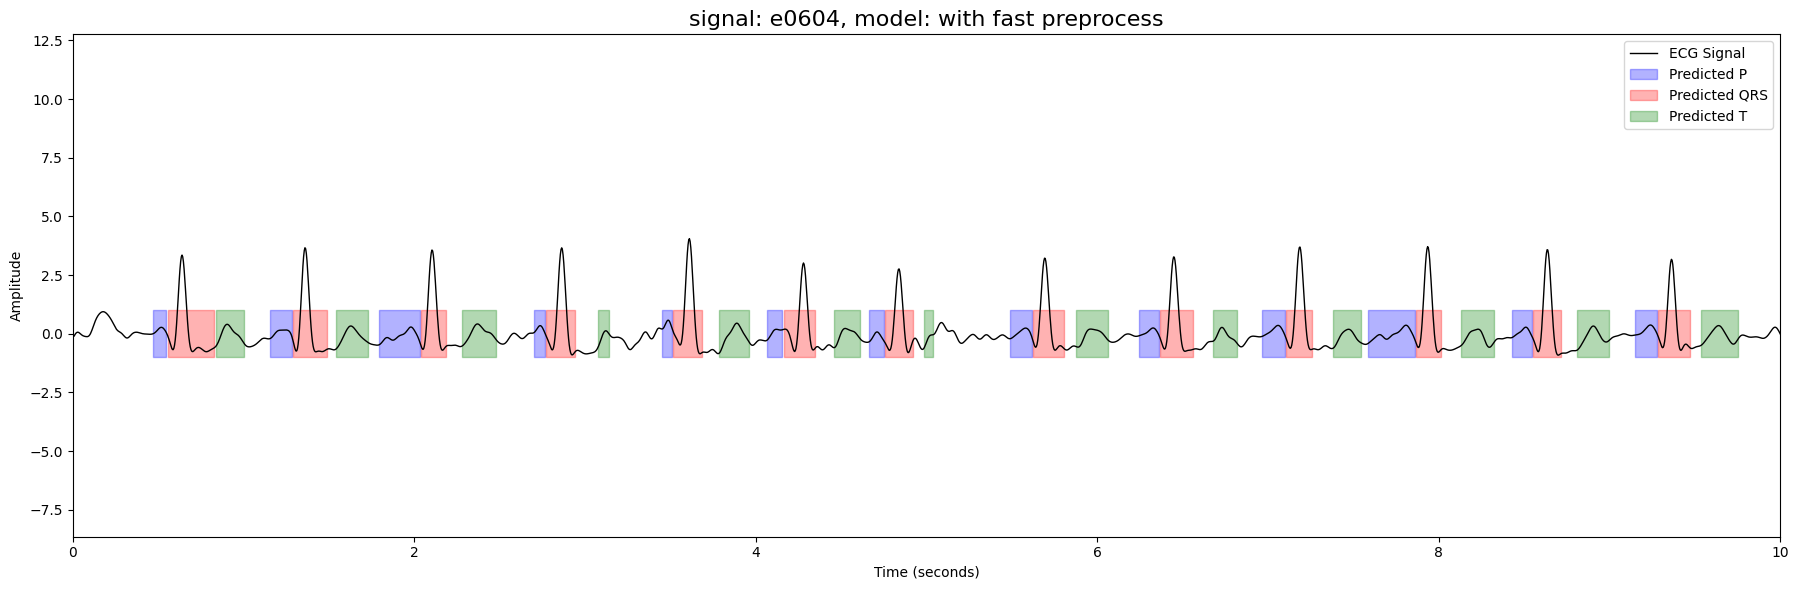

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


In [17]:
def div_signal(signal, window_size = 240):
    segments = []
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
            window = signal[:, :, i:i+window_size]
            segments.append(window)
    signal = np.concatenate(segments, axis=2)
    signal = signal.reshape(-1)
    return signal
#record = wfdb.rdrecord(edb_path+'e0604')# Run prediction
base_path = '/kaggle/input/signal-classification-data/challenge-2021/'
rd_name = 'training/st_petersburg_incart/g1/I0006'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
signal = div_signal(signal)

if fs != 250:
    signal = resample_signal(signal, original_fs=fs, target_fs=250)
    fs = fs
mask = np.loadtxt('/kaggle/input/ecg-comp-2021-mask-extraction/masks/'+rd_name+'_mask.csv', delimiter=",", dtype=int)

boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")





# making dataset


In [18]:
def div_signal(signal, window_size = 240):
    segments = []
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
            window = signal[:, :, i:i+window_size]
            segments.append(window)
    signal = np.concatenate(segments, axis=2)
    signal = signal.reshape(-1)
    return signal

In [19]:

import joblib
Type_model = joblib.load('/kaggle/input/ecg-classification/ecg_multi_class_model.pkl')
class_map = {
     0 : 'N',
     1 : 'L',
     2 : 'R',
     3 : '/',
     4 : 'V',
    5:'else'
}

In [20]:

import numpy as np
import pandas as pd
import wfdb
import random
import contextlib
import sys

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr
            
def extract_features_from_mask(record_name, path, mask_path, target_fs=250):
    
    record = wfdb.rdrecord(path)
    signal = record.p_signal[:, 0]
    fs = record.fs
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    signal = div_signal(signal)
    
    if fs != 250:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
        fs = target_fs
    try:
        mask = np.loadtxt(mask_path, delimiter=",", dtype=int)
        # print("found mask:",record_name)
    except:
        print("mask not found:",record_name)
        return pd.DataFrame([])
    boundaries = get_wave_boundaries(mask)
    all_predicted_masks = mask.reshape(1, -1)
    

    features_per_beat = extract_features_per_qrs(signal, all_predicted_masks.flatten(), fs)

    df = pd.DataFrame(features_per_beat)
    if df.empty:
        return df

    df = df[['R_index'] + [col for col in df.columns if col != 'R_index']]
    y_pred = Type_model.predict(df)

    for i, feature_dict in enumerate(features_per_beat):
        Type = class_map[int(y_pred[i])]
        feature_dict["Type"] = Type

    df = pd.DataFrame(features_per_beat)
    df['record_name'] = record_name
    df['beat_number'] = range(1, len(df) + 1)

    main_cols = ['record_name', 'beat_number', 'Type', 'R_index']
    df = df[main_cols + [col for col in df.columns if col not in main_cols]]
    print('end')
    
    return df

In [21]:
import os
import wfdb
import pandas as pd
import contextlib
from functools import partial
import sys


@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Patch tqdm globally if needed
silent_tqdm = partial(tqdm, disable=True)




def batch_features(mitdb_path, mit_records, target_fs=250, save_csv=False, output_csv="all_features.csv"):
    
    all_dfs = []
    #print('mit_records,',mit_records)
    #for record_name in tqdm(mit_records, total=len(mit_records), desc="Processing mit_records"):
    #for record_name in tqdm(mit_records, total=len(mit_records), desc="Processing mit_records"):
    for record_name in tqdm( mit_records, total=len(mit_records), desc="mask detection"):
        full_path = os.path.join(mitdb_path, record_name)
        with suppress_output():
            df = extract_features_from_mask(record_name, full_path, '/kaggle/input/ecg-comp-2021-mask-extraction/masks/'+record_name+'_mask.csv', target_fs=250)   
            
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs, ignore_index=True)

    if save_csv:
        combined_df.to_csv(output_csv, index=False)
        print(f"Saved combined features to {output_csv}")

    return combined_df


In [22]:
!wget -r -N -c -np https://physionet.org/files/challenge-2021/1.0.3/RECORDS
with open('/kaggle/working/physionet.org/files/challenge-2021/1.0.3/RECORDS', 'r') as file:
    folder_paths = [line.strip() for line in file]
!rm -rf /kaggle/working/physionet.org


--2025-05-27 18:56:23--  https://physionet.org/files/challenge-2021/1.0.3/RECORDS
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2073 (2.0K) [text/plain]
Saving to: ‘physionet.org/files/challenge-2021/1.0.3/RECORDS’

physionet.org/files 100%[===================>]   2.02K  --.-KB/s    in 0s      

2025-05-27 18:56:23 (415 MB/s) - ‘physionet.org/files/challenge-2021/1.0.3/RECORDS’ saved [2073/2073]

FINISHED --2025-05-27 18:56:23--
Total wall clock time: 0.4s
Downloaded: 1 files, 2.0K in 0s (415 MB/s)


In [23]:
#mit_records = ['123']
import os
import random

def get_all_records(directory, prefix="", extension=".hea"):
    # Remove extension and ensure unique filenames
    #print(directory)
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    unique_files = list(set(files))
    
    # Add the prefix to each filename
    full_paths = [os.path.join(prefix, f) for f in unique_files]
    
    return full_paths

base_path = "/kaggle/input/signal-classification-data/challenge-2021/"
full_records = []
for path in folder_paths:
    full_records += get_all_records(base_path+path,path)

full_records.sort()
# random.shuffle(full_records)
print(len(full_records))


88253


In [24]:
#nb = len(df_descreption['ecg_id'])Fork of mitdb norm

#df_all = batch_features(base_path, full_records[:44125], save_csv=True,output_csv="ecg-comp-2021-features.csv") 
# 29417
df_all = batch_features(base_path, full_records[:29417], save_csv=True,output_csv="ecg-comp-2021-features.csv") 


mask detection: 100%|██████████| 29417/29417 [10:43:30<00:00,  1.31s/it]
/tmp/ipykernel_13/571022399.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_dfs, ignore_index=True)


Saved combined features to ecg-comp-2021-features.csv


# display features

## functions

In [25]:
import matplotlib.pyplot as plt
import numpy as np
def plot_beat_with_features(signal, mask, beat_features, fs, window_start=0):

    time = np.arange(len(signal)) / fs

    plt.figure(figsize=(15, 5))
    plt.plot(time, signal, color='black', label='ECG Signal', alpha=0.8)

    # Mask indices
    p_indices = np.where(mask == 1)[0]
    qrs_indices = np.where(mask == 2)[0]
    t_indices = np.where(mask == 3)[0]

    # --- Highlight P wave
    if len(p_indices) > 0:
        plt.plot(time[p_indices], signal[p_indices], color='blue', label='P Wave', linewidth=2, alpha=0.6)

    # --- Highlight QRS
    if len(qrs_indices) > 0:
        plt.plot(time[qrs_indices], signal[qrs_indices], color='red', label='QRS Complex', linewidth=2, alpha=0.6)

    # --- Highlight T wave
    if len(t_indices) > 0:
        plt.plot(time[t_indices], signal[t_indices], color='green', label='T Wave', linewidth=2, alpha=0.6)

    # --- Duration bars
    if len(p_indices) > 0:
        plt.axvspan(time[p_indices[0]], time[p_indices[-1]], color='blue', alpha=0.1, label='Durée P')
    if len(qrs_indices) > 0:
        plt.axvspan(time[qrs_indices[0]], time[qrs_indices[-1]], color='red', alpha=0.1, label='Durée QRS')
    if len(t_indices) > 0:
        plt.axvspan(time[t_indices[0]], time[t_indices[-1]], color='green', alpha=0.1, label='Durée T')

    # --- P and R peak markers
    print("beat_features: ", beat_features)
    if 'P_index' in beat_features and beat_features['P_index'] is not None :
        p_idx = int(beat_features['P_index']) - window_start
        if 0 <= p_idx < len(signal):
            plt.plot(time[p_idx], signal[p_idx], 'bo', label='P Peak')
            plt.annotate(f'P Peak\n{signal[p_idx]:.2f}', (time[p_idx], signal[p_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

    if 'R_index' in beat_features and beat_features['R_index'] is not None :
        r_idx = int(beat_features['R_index']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'ro', label='R Peak')
            plt.annotate(f'R Peak\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    if 'R_reel' in beat_features and beat_features['R_reel'] is not None:
        r_idx = int(beat_features['R_reel']) - window_start
        if 0 <= r_idx < len(signal):
            plt.plot(time[r_idx], signal[r_idx], 'yo', label='R Reel')
            plt.annotate(f'R Reel\n{signal[r_idx]:.2f}', (time[r_idx], signal[r_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='yellow')
    if 'Q_index' in beat_features and beat_features['Q_index'] is not None:
        q_idx = int(beat_features['Q_index']) - window_start
        if 0 <= q_idx < len(signal):
            plt.plot(time[q_idx], signal[q_idx], 'mo', label='Q Peak')
            plt.annotate(f'Q Peak\n{signal[q_idx]:.2f}', (time[q_idx], signal[q_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='magenta')

    if 'S_index' in beat_features and beat_features['S_index'] is not None:
        s_idx = int(beat_features['S_index']) - window_start
        if 0 <= s_idx < len(signal):
            plt.plot(time[s_idx], signal[s_idx], 'co', label='S Peak')
            plt.annotate(f'S Peak\n{signal[s_idx]:.2f}', (time[s_idx], signal[s_idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', color='cyan')


    if 'T_index' in beat_features and beat_features['T_index'] is not None:
        t_idx = int(beat_features['T_index']) - window_start
        if 0 <= t_idx < len(signal):
            plt.plot(time[t_idx], signal[t_idx], 'go', label='T Peak')
            plt.annotate(f'T Peak\n{signal[t_idx]:.2f}', (time[t_idx], signal[t_idx]),
                        textcoords="offset points", xytext=(0, 10), ha='center', color='green')


    # --- Interval lines (flat)
    y_level = min(signal) - 0.2  # slightly below signal
    if len(p_indices) > 0 and len(qrs_indices) > 0:
      plt.hlines(y_level, time[p_indices[0]], time[qrs_indices[0]], colors='purple', linestyles='--', label='Intervalle PR')
    if len(qrs_indices) > 0 and len(t_indices) > 0:
        plt.hlines(y_level - 0.2, time[qrs_indices[0]], time[t_indices[-1]], colors='orange', linestyles=':', label='Intervalle QT')
        plt.hlines(y_level - 0.4, time[qrs_indices[-1]], time[t_indices[0]], colors='green', linestyles='-.', label='Intervalle ST')

        # --- Final Touch
    plt.title("Visualisation d'un battement ECG avec caractéristiques")
    plt.xlabel('Temps (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()

    # Enforce min y-range of 5
    ymin = min(signal)
    ymax = max(signal)
    if ymax - ymin < 10:
        midpoint = (ymin + ymax) / 2
        plt.ylim(midpoint - 5, midpoint + 5)

    plt.show()

In [26]:
def makemask(lenth, feat ):
    freq = 250  # Hz
    ms_per_sample = 1000 / freq  # 4 ms per sample
    
    # Assume 'beat' is your row, a pandas Series
    start_global = feat['start']
    end_global = feat['end']
    
    Q_index = feat['Q_index']
    S_index = feat['S_index']
    Intervalle_ST_ms = feat['Intervalle_ST_ms']
    Intervalle_PR_ms = feat['Intervalle_PR_ms']
    
    
    # Start and End
    P_start = start_global 
    P_end = P_start + feat['Duree_P_ms']/ ms_per_sample
    QRS_start =  P_start + Intervalle_PR_ms / ms_per_sample
    
    # T start
    T_start = end_global - feat['Duree_T_ms']/ ms_per_sample
    T_end = end_global
    QRS_end = T_end - Intervalle_ST_ms / ms_per_sample
    
    # Results
    P_start -=start_global
    P_end -=start_global
    QRS_start -=start_global
    QRS_end -=start_global
    T_start -=start_global
    T_end-=start_global
    
    
    mask = np.zeros(lenth)
    mask [int(P_start):int(P_end)]=1
    mask [int(QRS_start):int(QRS_end)]=2
    mask [int(T_start):int(T_end)]=3
    
    return mask


In [27]:
import wfdb
def display_beat(record_name,beat_number):
    
    feat = df[(df['record_name'] == record_name) & (df['beat_number'] == beat_number)].iloc[0]
    if feat is not None:
        start, end = feat['start'], feat['end']
        record = []
        mitdb_path = "/kaggle/input/signal-classification-data/challenge-2021/"
            
        record_name = mitdb_path+str(record_name)
        record = wfdb.rdrecord(record_name)# Run prediction
        
        #record = wfdb.rdrecord(edb_path+'e0129')# Run prediction
        
        signal = record.p_signal[:, 0]  # lead I
        fs = record.fs
        
        #signal=signal[int(start):int(end)]
        if fs != 250:
                  signal = resample_signal(signal, original_fs=fs, target_fs=250)
                  fs = 250
        signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
        signal = div_signal(signal)
        
        mask = makemask(end-start,feat)
        plot_beat_with_features(
          signal[start:end],
          mask,
          beat_features=feat,
          fs=fs,
          window_start=start
        ) 
        
    else:
        print("no beat")
    



## display beat

In [28]:
import pandas as pd


df = pd.read_csv('/kaggle/working/ecg-comp-2021-features.csv')
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,record_name,beat_number,Type,R_index,start,end,qrs_start,qrs_end,p_start,p_end,...,Slope_RS,P_symmetry,T_inversion,QRS_axis_estimate,Heart_rate_bpm,Premature_beat,Local_RR_variability,Local_RMSSD,Bigeminy,Trigeminy
0,training/chapman_shaoxing/g1/JS00001,1,N,377,319,437,342,406,319.0,341.0,...,22.586543,0.558631,1,0.692657,NaN,0,0.000000,0.0,0,0
1,training/chapman_shaoxing/g1/JS00001,2,N,496,440,549,469,521,440.0,468.0,...,23.599539,0.800811,1,0.941051,126.050420,0,0.000000,0.0,0,0
2,training/chapman_shaoxing/g1/JS00001,3,N,624,554,719,593,675,554.0,592.0,...,-50.714228,0.439443,1,-0.180181,117.187500,0,0.000000,0.0,0,0
3,training/chapman_shaoxing/g1/JS00001,4,else,743,720,764,720,743,NaN,NaN,...,0.000000,0.000000,0,0.999999,126.050420,0,18.000000,0.0,0,0
4,training/chapman_shaoxing/g1/JS00001,5,else,769,765,833,765,792,NaN,NaN,...,17.793139,0.000000,1,0.727667,576.923077,1,16.970563,36.0,0,0


beat_features:  record_name             training/georgia/g4/E03772
beat_number                                      9
Type                                             N
R_index                                       2004
start                                         1952
end                                           2113
qrs_start                                     1987
qrs_end                                       2032
p_start                                     1952.0
p_end                                       1986.0
t_start                                     2036.0
t_end                                       2113.0
Duree_P_ms                                   140.0
Duree_QRS_ms                                 184.0
Duree_T_ms                                   312.0
Intervalle_PR_ms                             140.0
Intervalle_QT_ms                             504.0
Intervalle_ST_ms                              16.0
P_index                                       1968
Amplitude_P    

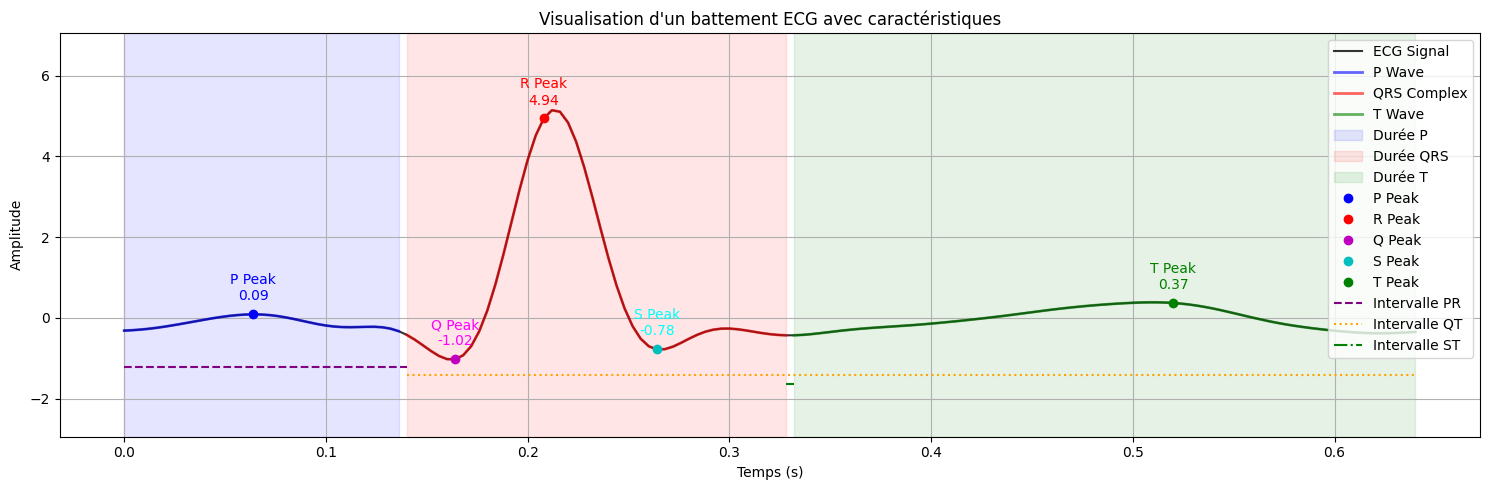

beat_features:  record_name             training/cpsc_2018/g7/A6014
beat_number                                      23
Type                                              N
R_index                                        4251
start                                          4187
end                                            4353
qrs_start                                      4236
qrs_end                                        4296
p_start                                      4187.0
p_end                                        4235.0
t_start                                      4320.0
t_end                                        4353.0
Duree_P_ms                                    196.0
Duree_QRS_ms                                  244.0
Duree_T_ms                                    136.0
Intervalle_PR_ms                              196.0
Intervalle_QT_ms                              468.0
Intervalle_ST_ms                               96.0
P_index                                        4

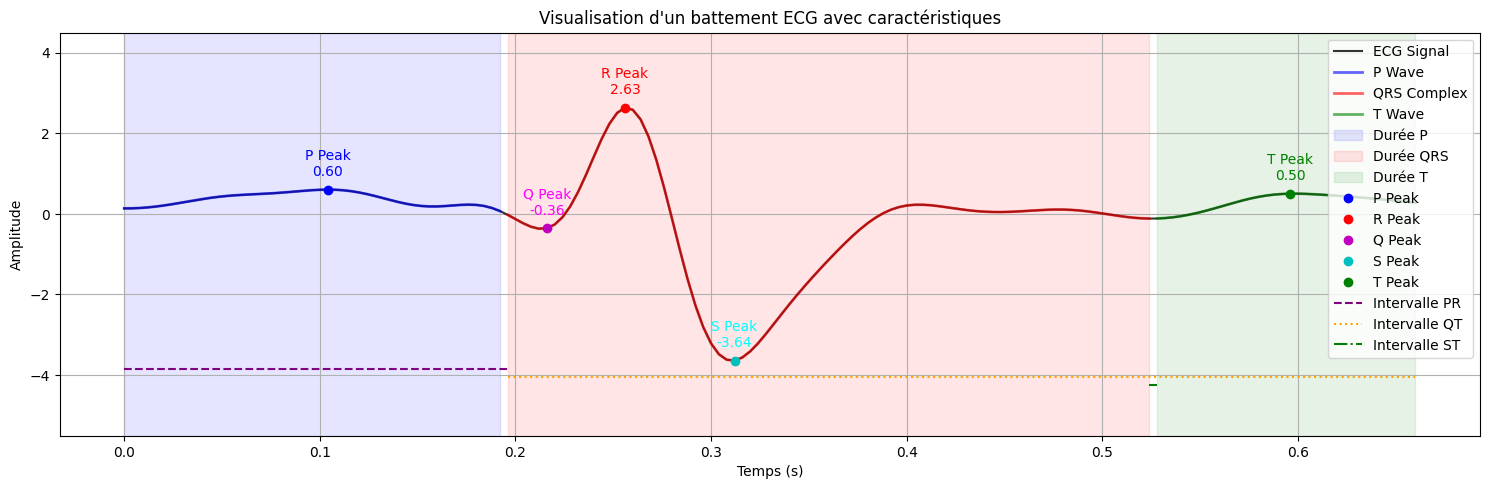

beat_features:  record_name             training/georgia/g1/E00973
beat_number                                      1
Type                                             N
R_index                                        183
start                                          115
end                                            196
qrs_start                                      141
qrs_end                                        196
p_start                                      115.0
p_end                                        139.0
t_start                                        NaN
t_end                                          NaN
Duree_P_ms                                   100.0
Duree_QRS_ms                                 224.0
Duree_T_ms                                     0.0
Intervalle_PR_ms                             104.0
Intervalle_QT_ms                               0.0
Intervalle_ST_ms                               0.0
P_index                                        127
Amplitude_P    

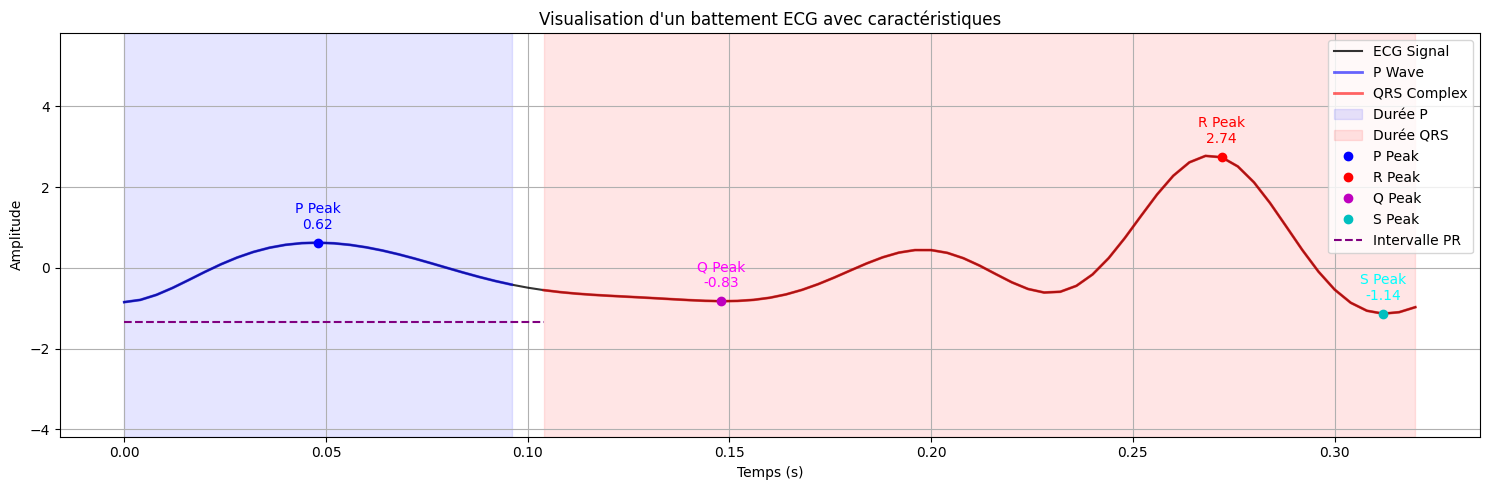

beat_features:  record_name             training/cpsc_2018/g5/A4383
beat_number                                      14
Type                                              N
R_index                                        2181
start                                          2111
end                                            2272
qrs_start                                      2160
qrs_end                                        2211
p_start                                      2111.0
p_end                                        2159.0
t_start                                      2218.0
t_end                                        2272.0
Duree_P_ms                                    196.0
Duree_QRS_ms                                  208.0
Duree_T_ms                                    220.0
Intervalle_PR_ms                              196.0
Intervalle_QT_ms                              448.0
Intervalle_ST_ms                               28.0
P_index                                        2

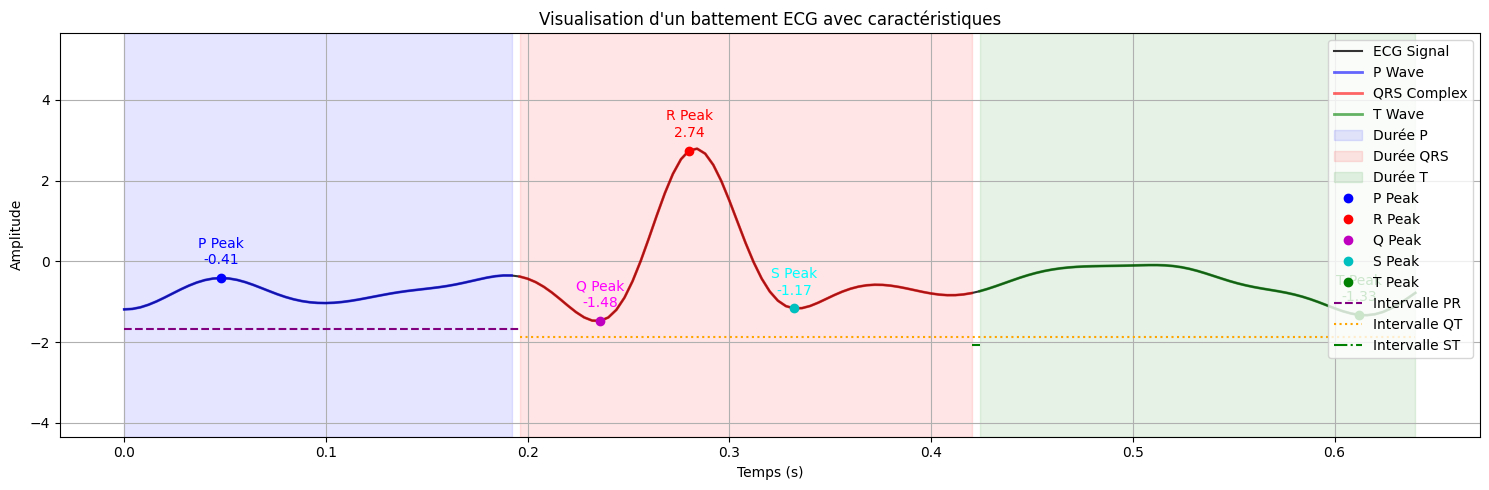

beat_features:  record_name             training/cpsc_2018/g4/A3736
beat_number                                       4
Type                                              N
R_index                                         682
start                                           636
end                                             719
qrs_start                                       658
qrs_end                                         700
p_start                                       636.0
p_end                                         657.0
t_start                                       715.0
t_end                                         719.0
Duree_P_ms                                     88.0
Duree_QRS_ms                                  172.0
Duree_T_ms                                     20.0
Intervalle_PR_ms                               88.0
Intervalle_QT_ms                              244.0
Intervalle_ST_ms                               60.0
P_index                                         

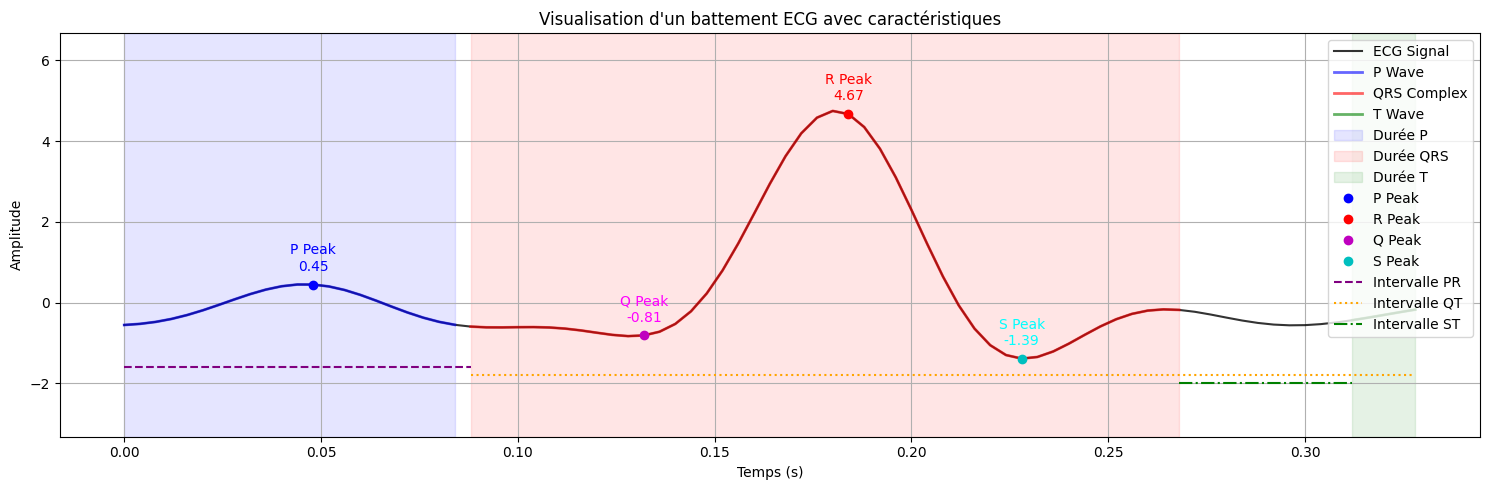

In [29]:
import random
for i in range(5):
    index = random.randint(0, len(df)-1)
    record_name = df.iloc[index]["record_name"]
    beat_number = df.iloc[index]["beat_number"]
    display_beat(record_name,beat_number)

# Signal features

In [30]:
#print(df_all['record_name'])
df_all.count()["record_name"]

434446

In [31]:
df_all = df_all[df_all['Duree_QRS_ms'] >= 40]
df_all.count()["record_name"]

433741

In [32]:
df_all.iloc[0]

record_name             training/chapman_shaoxing/g1/JS00001
beat_number                                                1
Type                                                       N
R_index                                                  377
start                                                    319
end                                                      437
qrs_start                                                342
qrs_end                                                  406
p_start                                                319.0
p_end                                                  341.0
t_start                                                407.0
t_end                                                  437.0
Duree_P_ms                                              92.0
Duree_QRS_ms                                           260.0
Duree_T_ms                                             124.0
Intervalle_PR_ms                                        92.0
Intervalle_QT_ms        

In [33]:


def flatten_feature_dict(d, keep_sums_for=None, keep_means_for=None):
    if keep_sums_for is None:
        keep_sums_for = {'T_inversion', 'Premature_beat', 'Bigeminy', 'Trigeminy'}
    if keep_means_for is None:
        keep_means_for = {'T_inversion', 'Premature_beat', 'Bigeminy', 'Trigeminy'}

    flat = {}
    for k, v in d.items():
        if isinstance(v, dict):
            for subk, subv in v.items():
                if pd.isna(subv):
                    continue  # Skip NaNs entirely
                if subk == 'sum' and k not in keep_sums_for:
                    continue
                if subk == 'mean' and k not in keep_means_for:
                    continue
                if subk in {'min', 'max', 'std'} and k in keep_sums_for:
                    continue  # Skip stats for binary columns
                flat[f'{k}_{subk}'] = subv
        else:
            if not pd.isna(v):
                flat[k] = v
    return flat

In [34]:
from collections import Counter

def extract_signal_features(df_signal):
    # Aggregation
    agg_funcs = {
        'Duree_QRS_ms': ['mean', 'std', 'min', 'max'],
        'Duree_P_ms': ['mean', 'std', 'min', 'max'],
        'Duree_T_ms': ['mean', 'std', 'min', 'max'],
        'Intervalle_QT_ms': ['mean', 'std', 'min', 'max'],
        'Intervalle_PR_ms': ['mean', 'std', 'min', 'max'],
        'Intervalle_ST_ms': ['mean', 'std', 'min', 'max'],
        'Amplitude_P': ['mean', 'std', 'min', 'max'],
        'Amplitude_Q': ['mean', 'std', 'min', 'max'],
        'Amplitude_R': ['mean', 'std', 'min', 'max'],
        'Amplitude_S': ['mean', 'std', 'min', 'max'],
        'Amplitude_T': ['mean', 'std', 'min', 'max'],
        'T/R_ratio': ['mean', 'std', 'min', 'max'],
        'P/R_ratio': ['mean', 'std', 'min', 'max'],
        'QRS_area': ['mean', 'std', 'min', 'max'],
        'Slope_QR': ['mean', 'std', 'min', 'max'],
        'Slope_RS': ['mean', 'std', 'min', 'max'],
        'Heart_rate_bpm': ['mean', 'std', 'min', 'max'],
        'Local_RMSSD': ['mean', 'std', 'min', 'max'],
        'T_inversion': ['sum', 'mean'],
        'Premature_beat': ['sum'],
        'Bigeminy': ['sum'],
        'Trigeminy': ['sum'],
    }

    agg_df = df_signal.agg(agg_funcs)
    agg_df.columns = [''.join(col).strip() for col in agg_df.columns.values]
    agg_features = agg_df.to_dict()

    beat_types = df_signal['Type'].tolist()
    type_counts = Counter(beat_types)
    total_beats = len(df_signal)

    type_features = {
        f'count_{t}': type_counts.get(t, 0)
        for t in ['N', 'L', 'R', '/', 'V', 'else']
    }
    type_features.update({
        f'ratio_{t}': type_counts.get(t, 0) / total_beats if total_beats > 0 else 0
        for t in ['N', 'L', 'R', '/', 'V', 'else']
    })

    derived_features = {
        'percent_T_inversion': df_signal['T_inversion'].mean(),
        'QRS_prolonged_ratio': (df_signal['Duree_QRS_ms'] > 120).mean(),
        'QT_prolonged_ratio': (df_signal['Intervalle_QT_ms'] > 450).mean(),
        'PVC_ratio': type_counts.get('V', 0) / total_beats if total_beats > 0 else 0,
        'num_beats': total_beats,
        'std_Intervalle_RR_ms': df_signal['Intervalle_RR_ms'].std(skipna=True)
    }

    signal_features = {
        **agg_features,
        **type_features,
        **derived_features
    }

    return flatten_feature_dict(signal_features)


In [35]:
signal_feature_list = []

for record_name, group_df in df_all.groupby('record_name'):
    features = extract_signal_features(group_df)
    features['record_name'] = record_name

    signal_feature_list.append(features)

df_signal_features = pd.DataFrame(signal_feature_list)
df_signal_features = df_signal_features[['record_name'] + [col for col in df_signal_features.columns if col != 'record_name']]
df_signal_features.count()["record_name"]

29406

In [36]:
df_signal_features.columns

Index(['record_name', 'Duree_QRS_ms_std', 'Duree_QRS_ms_min',
       'Duree_QRS_ms_max', 'Duree_P_ms_std', 'Duree_P_ms_min',
       'Duree_P_ms_max', 'Duree_T_ms_std', 'Duree_T_ms_min', 'Duree_T_ms_max',
       'Intervalle_QT_ms_std', 'Intervalle_QT_ms_min', 'Intervalle_QT_ms_max',
       'Intervalle_PR_ms_std', 'Intervalle_PR_ms_min', 'Intervalle_PR_ms_max',
       'Intervalle_ST_ms_std', 'Intervalle_ST_ms_min', 'Intervalle_ST_ms_max',
       'Amplitude_P_std', 'Amplitude_P_min', 'Amplitude_P_max',
       'Amplitude_Q_std', 'Amplitude_Q_min', 'Amplitude_Q_max',
       'Amplitude_R_std', 'Amplitude_R_min', 'Amplitude_R_max',
       'Amplitude_S_std', 'Amplitude_S_min', 'Amplitude_S_max',
       'Amplitude_T_std', 'Amplitude_T_min', 'Amplitude_T_max',
       'T/R_ratio_std', 'T/R_ratio_min', 'T/R_ratio_max', 'P/R_ratio_std',
       'P/R_ratio_min', 'P/R_ratio_max', 'QRS_area_std', 'QRS_area_min',
       'QRS_area_max', 'Slope_QR_std', 'Slope_QR_min', 'Slope_QR_max',
       'Slope_RS_std

In [37]:
print(df_signal_features.iloc[0])


record_name             training/chapman_shaoxing/g1/JS00001
Duree_QRS_ms_std                                   94.729336
Duree_QRS_ms_min                                        40.0
Duree_QRS_ms_max                                       380.0
Duree_P_ms_std                                     51.678746
                                        ...                 
QRS_prolonged_ratio                                 0.777778
QT_prolonged_ratio                                  0.166667
PVC_ratio                                                0.0
num_beats                                                 18
std_Intervalle_RR_ms                              151.173838
Name: 0, Length: 78, dtype: object


In [38]:
df_signal_features.iloc[[0, 1, -2, -1], [0] + list(range(59, 72))]


,record_name,Trigeminy_sum,count_N,count_L,count_R,count_/,count_V,count_else,ratio_N,ratio_L,ratio_R,ratio_/,ratio_V,ratio_else
0,training/chapman_shaoxing/g1/JS00001,6.0,13,0,0,0,0,5,0.722222,0.0,0.0,0.0,0.0,0.277778
1,training/chapman_shaoxing/g1/JS00002,0.0,8,0,0,0,0,0,1.000000,0.0,0.0,0.0,0.0,0.000000
29404,training/georgia/g8/E07494,0.0,8,0,0,0,0,0,1.000000,0.0,0.0,0.0,0.0,0.000000
29405,training/georgia/g8/E07495,0.0,14,0,0,0,0,0,1.000000,0.0,0.0,0.0,0.0,0.000000


In [39]:
df_signal_features.to_csv("mitdb_arr_signal_features.csv",index=False)

!cp '/kaggle/input/ptb-xl/physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv' '/kaggle/working/'
!cp '/kaggle/input/ptb-xl/physionet.org/files/ptb-xl/1.0.3/scp_statements.csv' '/kaggle/working/'